# Getting data/Kaggle
In order to enter a Kaggle competition, or even just work with the images, we must first get the data.

## Getting data

There are a couple of ways to get data.

### Option 1: Kaggle-cli
To download the official [Kaggle](www.kaggle.com) datasets, the easiest way is to use the [Kaggle cli](https://github.com/floydwch/kaggle-cli).

This is a screenscraper, so often needs to be updated to catch website updates.

__To install/upgrade:__
`pip install kaggle-cli --upgrade`

__To get data:__
`kg download -u [username] -p [password] -c [competition-name]`

The competition name is the part after the main URL.

E.g., in https://www.kaggle.com/c/planet-understanding-the-amazon-from-space, the competition name is _planet-understanding-the-amazon-from-space_.

__Note: You must go to the competition in Kaggle and click download first, in order to accept the competition terms and conditions.__

### Option 2: Chrome wget extension
Another option is to use [CurlWget](https://chrome.google.com/webstore/detail/curlwget/jmocjfidanebdlinpbcdkcmgdifblncg?hl=en), a Chrome extension.

With this, simply click the download link to get what you want, and it will generate a `wget` command that you can paste into your Ubuntu console to download the data.

This approach has the advantage that you can download just specific things. For example, instead of downloading all of the contest data, you can just download the folder containing JPG images.

### Note on symbolic links
In Ubuntu, you can create symbolic links (like shortcuts). For example, you can make the "data folder" in your Jupyter notebook directory point to a top level directory called data.

To view symbolic links, use the `ls -l [directory]` command. E.g., `ls -l courses/dl1`. Symbolic links can be identified by `->`.

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/sym-links.jpg" width=500, height=400>

## Dog Breeds
We will enter the [dog breed identification contest](https://www.kaggle.com/c/dog-breed-identification/).

First get the data using the steps above.

In [1]:
# Do our usual import and setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Set up our imports
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# Set up our paths, size, architecture, batch size, etc.
PATH="data/dogbreed/"
size=224
architecture=resnext101_64
batch_size=58

After doing some initial set up, we do some data exploration to see what the downloaded data looks like.

In [4]:
label_csv = f'{PATH}labels.csv'

# num of rows -1 (to account for the header)
n = len(list(open(label_csv)))-1

# random 20% of rows to use as the validation set
# get cross validation indexes
val_idxs = get_cv_idxs(n)

In [5]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

In [6]:
# Take a look and see the files we have
!ls {PATH}

labels.csv  sample_submission.csv  test  tmp  train


In [7]:
# Take a look inside labels using a pandas dataframe
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
label_df.count()

id       10222
breed    10222
dtype: int64

In [9]:
# We then get the number of breeds
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [10]:
# We're going to use data augmentation, so let's set up our transforms
transforms = tfms_from_model(architecture, size, aug_tfms=transforms_side_on, max_zoom=1.1)

# This time we're reading from a CSV instead of from a path
# We also use the validation indexes we generated
# Because the file names in the id column of the csv don't have jpg on the end,
# we pass in .jpeg as a suffix as well.
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=transforms, bs=batch_size)

In [11]:
# Let's check out a file
file_name = PATH+data.trn_ds.fnames[0]
file_name

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

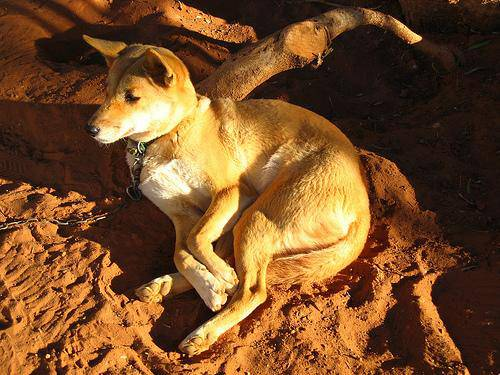

In [12]:
img = PIL.Image.open(file_name)
img

In [13]:
img.size

(500, 375)

In [14]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [15]:
# Take a look at all the file sizes
size_d

{'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg': (500, 375),
 'train/001cdf01b096e06d78e9e5112d419397.jpg': (500, 375),
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg': (500, 500),
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg': (500, 375),
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg': (500, 470),
 'train/002a283a315af96eaea0e28e7163b21b.jpg': (231, 227),
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg': (500, 332),
 'train/0067dc3eab0b3c3ef0439477624d85d6.jpg': (402, 343),
 'train/006cc3ddb9dc1bd827479569fcdc52dc.jpg': (250, 223),
 'train/00792e341f3c6eb33663e415d0715370.jpg': (200, 192),
 'train/007b5a16db9d9ff9d7ad39982703e429.jpg': (374, 212),
 'train/007b8a07882822475a4ce6581e70b1f8.jpg': (333, 500),
 'train/007ff9a78eba2aebb558afea3a51c469.jpg': (500, 375),
 'train/008ba178d6dfc1a583617470d19c1673.jpg': (390, 320),
 'train/009509be3ca7cce0ff9e37c8b09b1125.jpg': (400, 346),
 'train/00a338a92e4e7bf543340dc849230e75.jpg': (200, 280),
 'train/00a366d4b4a9bbb6c8a63126697b7656.jpg': (500, 375

In [16]:
# Get the row size and column size from the list above
row_size, column_size = list(zip(*size_d.values()))

In [17]:
row_size=np.array(row_size)
column_size=np.array(column_size)

In [18]:
row_size[:5]

array([500, 500, 500, 500, 500])

In [19]:
column_size[:5]

array([375, 375, 500, 375, 470])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

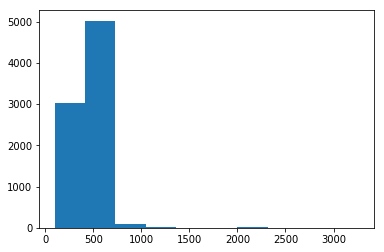

In [20]:
# See how big most of our images are
# Most are 500 wide 
plt.hist(row_size)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

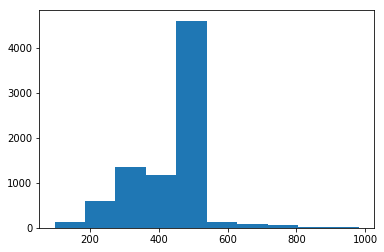

In [21]:
# We can take out some of the outliers to get a more detailed view
plt.hist(row_size[row_size<1000])

We could do the same for the columns. This is just to make sure we don't have any super wide/big images, etc.

In [22]:
# Get the size of the training and test data sets
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [23]:
# Get the num of classes
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Setting up the model
Now that we've done some data exploration, we can set up the model.

In [24]:
# Convenience method
def get_data(size, batch_size):
    transforms = tfms_from_model(architecture, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4,
                                       val_idxs=val_idxs, suffix='.jpg', tfms=transforms, bs=batch_size)
    return data if size>300 else data.resize(340, 'tmp')

### Precompute
Set precompute to do and do our initial training for the final layers.

In [25]:
data = get_data(size, batch_size)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [26]:
learn = ConvLearner.pretrained(architecture, data, precompute=True)

In [27]:
learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.92608 0.39313 0.90853]                            
[1.      0.43449 0.36583 0.91092]                            
[2.      0.30892 0.30343 0.91331]                            
[3.      0.25296 0.31098 0.91906]                            
[4.      0.19217 0.30561 0.91667]                            



### Augment
Next we turn precompute off so we can use data augmentations (transformations).

In [28]:
from sklearn import metrics

In [29]:
data = get_data(size, batch_size)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [30]:
learn = ConvLearner.pretrained(architecture, data, precompute=True, ps=0.5)

In [31]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      1.13687 0.4544  0.90079]                           
[1.      0.54595 0.39578 0.91236]                            



In [32]:
learn.precompute=False

In [33]:
# Use the learning rate finder to check the learning rate is optimal
# Tried 5 epochs to check the accuracy was getting better, then stuck with that
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      0.4454  0.27167 0.92241]                            
[1.      0.40716 0.26172 0.92672]                            
[2.      0.38718 0.25009 0.92522]                            
[3.      0.35889 0.23875 0.93343]                            
[4.      0.33432 0.23403 0.93151]                            



In [34]:
# Save our weights
learn.save('224_pre')

In [35]:
learn.load('224_pre')

### Increase size
Then we increase the size of the images.

A tip Jeremy has is to train on smaller images, then train on larger images, so the images are different. It prevents overfitting. Also, training on the small images is faster, so do it first.

In [36]:
learn.set_data(get_data(299, batch_size))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [37]:
# If the training loss is greater than the validation loss, we're underfiting
# We can up the cycle_mult parameter to correct this
# (We'd do 3 epochs normally)
learn.fit(1e-2, 1, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.34207 0.22987 0.93343]                            



In [39]:
# Then try using test time augmentation to see if that gives better results
log_preds, y = learn.TTA()

In [40]:
probs = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, probs)

0.23592007515597008

In [42]:
accuracy(np.mean((log_preds), 0), y)

0.9339530332681018

We didn't unfreeze and try training more. This data is from image-net, that tuning the layers that were already pretrained on image-net anyway didn't make any difference.

## Create the submission
Now that we've trained our model, we want to submit it to Kaggle. In the evaluation section of the competition, you can see the requested format:

`id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.`

In [43]:
submission_csv = f'{PATH}sample_submission.csv'
submission_df = pd.read_csv(submission_csv)
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [44]:
# Take a look at the different classes we have.
# They can be accessed from our data object.
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [45]:
# We can also see all of the file names
data.test_ds.fnames

['test/de084b830010b6107215fef5d4a75b94.jpg',
 'test/6b423ca7020e70eb05732843c5d2bad1.jpg',
 'test/74aa7e201e0e93e13e87b986a7d31839.jpg',
 'test/a079f72193264bc5685e5d28d7372680.jpg',
 'test/583f7580fa5fec1266331fcf83b76fd6.jpg',
 'test/72cd7496a319c832f670fbb8d349217e.jpg',
 'test/ed9e75a553dbb4712addc1638693dc03.jpg',
 'test/6322fa7edb40af844609b4843a89b5fd.jpg',
 'test/d18de4f66f7d2ae8dffb08ec13b9bbc5.jpg',
 'test/8c567325012bf8d7daeff453ec959312.jpg',
 'test/bbecb2e61f07719abe32be3f36b3fac0.jpg',
 'test/7d3a1066521da895f915af31e8e739df.jpg',
 'test/a0256a9577f2e7c6631dd78556e4bab8.jpg',
 'test/87dafc44ed8ae792ea5c341d7cbb6df4.jpg',
 'test/1f2e9080823a6b093e7a4baa668393d2.jpg',
 'test/c65172e587bf02794e5b40f830bcb2af.jpg',
 'test/4f0b2dbc23fdef5f939144f456a62140.jpg',
 'test/a5049952a1a2ea0473e6520db5e4a4fb.jpg',
 'test/685ac2356ad42163b2141a41972e5c54.jpg',
 'test/bd405393e16688e5282b57d92bdbb97b.jpg',
 'test/cbb4039e5a16f80c02f3d188f98beaf7.jpg',
 'test/18cf06b0c6a59c6891bf6f5a42b

In [47]:
# Get predictions on the test set
# (We can't get accuracy since by definition we don't know)
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [48]:
# 10357 images, 120 possible breeds
# Think of it like a matri -- a list of images, then a probability for the breeds
probs.shape 

(10357, 120)

In [49]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [50]:
# Insert the IDs, but remove the test/ before the file name ([5:-4])
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [51]:
# Now we have the data in our submission format
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,0.000018,0.000110,0.000039,0.000007,0.000008,0.000004,0.000001,7.672430e-07,3.367392e-06,...,1.198677e-06,0.000002,6.501280e-06,1.887059e-06,0.000010,4.076534e-06,0.000017,0.000051,0.000002,1.166302e-06
1,6b423ca7020e70eb05732843c5d2bad1,0.000029,0.000325,0.000021,0.000039,0.000005,0.000002,0.000039,4.944084e-06,1.226995e-05,...,1.103837e-05,0.000002,1.619151e-06,5.791285e-07,0.000008,8.745586e-06,0.000345,0.000012,0.000052,2.870508e-05
2,74aa7e201e0e93e13e87b986a7d31839,0.000078,0.000045,0.000026,0.003559,0.000409,0.000041,0.000045,1.390945e-04,1.496679e-05,...,5.939487e-05,0.000068,1.552802e-04,7.329275e-05,0.000020,1.114965e-04,0.000083,0.000251,0.243859,3.139315e-05
3,a079f72193264bc5685e5d28d7372680,0.000064,0.000024,0.000049,0.000095,0.000048,0.000002,0.000177,2.290131e-06,1.020107e-05,...,1.873471e-05,0.000027,1.161859e-05,3.685182e-06,0.000012,2.911502e-05,0.000159,0.000013,0.000835,2.092581e-04
4,583f7580fa5fec1266331fcf83b76fd6,0.000005,0.000011,0.000016,0.000122,0.000003,0.000008,0.000003,1.663623e-06,5.128858e-07,...,9.443419e-07,0.000006,2.278522e-07,1.967593e-07,0.000003,8.487252e-07,0.000001,0.000015,0.000034,8.924907e-07


In [52]:
# Then we just save it to a file
submission = f'{PATH}subm/'
os.makedirs(submission, exist_ok=True)
df.to_csv(f'{submission}submission.gz', compression='gzip', index=False)

In [53]:
# Get a link to the file to download
FileLink(f'{submission}submission.gz')

/home/paperspace/fastai/courses/dl1/data/dogbreed/subm/submission.gz

# Predicting individual images
Sometimes you might want to predict just one image.

In [54]:
file_name = data.val_ds.fnames[0]

In [55]:
file_name

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

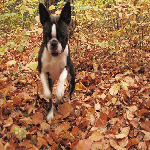

In [56]:
Image.open(PATH+file_name).resize((150, 150))

In [57]:
trn_tfms,val_tfms = tfms_from_model(architecture, size)

In [61]:
# Prediction expects a mini-batch -- a collection, we by indexing with
# im[None] we essentially create a mini-batch just containing that one image
im = val_tfms(Image.open(PATH+file_name))
preds = learn.predict_array(im[None])
np.argmax(preds)